In [101]:
from my_metrics import *
from sub_network import *
from data_loader import *
from plotting_utils import *

from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

In [102]:
image_dir1 = r"D:\ib811_database\S1_IEEE"
image_dir2 = r"D:\ib811_database\S2_IEEE"

images1 = load_images(image_dir1)
images2 = load_images(image_dir2)

pairs, labels = create_labels(images1, images2)

In [103]:
inputShape = (256, 256, 1)

inputA = Input(inputShape)
inputB = Input(inputShape)

featureExtractor = sub_network(inputShape)

featsA = featureExtractor(inputA)
featsB = featureExtractor(inputB)

distance = EuclideanDistance()([featsA, featsB])

outputs = Dense(1, activation="sigmoid")(distance)

model = Model(inputs=[inputA, inputB], outputs=outputs)

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_63 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_60 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_60 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_61 (Conv2D)          (None, 128, 128, 64)      184

test2_pairs.shape=(640, 2, 256, 256)
test2_labels.shape=(640,)
20/20 [==============================] - 1s 48ms/step


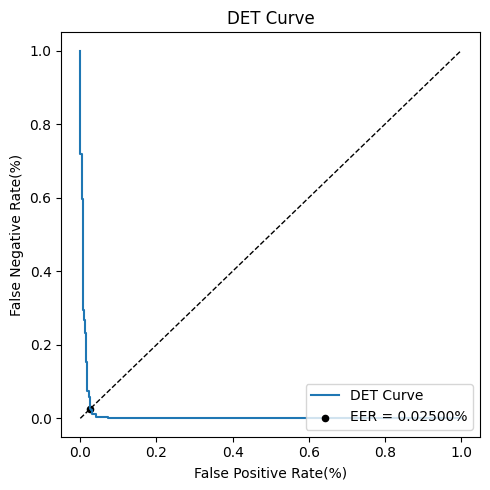

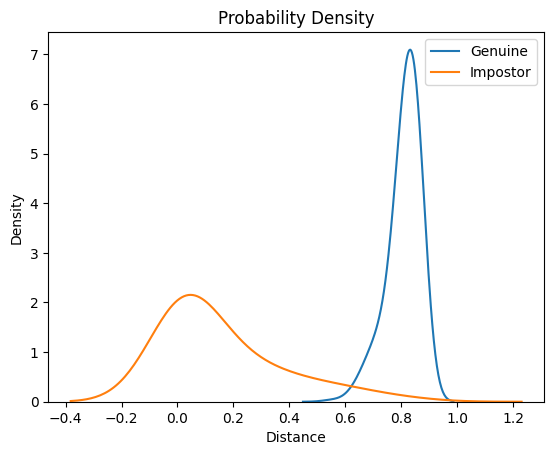

In [104]:
test2_pairs, test2_labels = pairs, labels

print("test2_pairs.shape={}".format(test2_pairs.shape))
print("test2_labels.shape={}".format(test2_labels.shape))

test2Pairs_0 = np.array([pair[0] for pair in test2_pairs]).reshape(-1, 256, 256, 1)
test2Pairs_1 = np.array([pair[1] for pair in test2_pairs]).reshape(-1, 256, 256, 1)

model.load_weights("snn.hdf5")
y_pred = model.predict([test2Pairs_0, test2Pairs_1]).ravel()
fpr, tpr, thresholds = roc_curve(test2_labels, y_pred)
eer, eer_threshold = compute_eer(fpr, tpr, thresholds)

EER = fpr[np.nanargmin(np.absolute((fpr - (1 - tpr))))]

with open("det_eer_data.txt", "w") as f:
    f.write(f"EER: {EER}\n")
    f.write(f"Threshold at EER: {eer_threshold}\n")

with open("det_curve_data.txt", "w") as f:
    f.write("False Positive Rate(%), False Negative Rate(%), Thresholds\n")
    for i in range(len(fpr)):
        f.write(f"{fpr[i]}, {1 - tpr[i]}, {thresholds[i]}\n") 

plot_det_curve(fpr, 1 - tpr, EER, label="DET Curve")

genuine_scores = y_pred[test2_labels == 1]
impostor_scores = y_pred[test2_labels == 0]

with open("scores_distribution.txt", "w") as f:
    f.write("Score Type,Score\n")
    for score in genuine_scores:
        f.write(f"Genuine,{score}\n")
    for score in impostor_scores:
        f.write(f"Impostor,{score}\n")

plot_density(genuine_scores, impostor_scores)

混淆矩陣:
 [[312   8]
 [  9 311]]

True Negatives: 312
False Positives: 8
False Negatives: 9
True Positives: 311


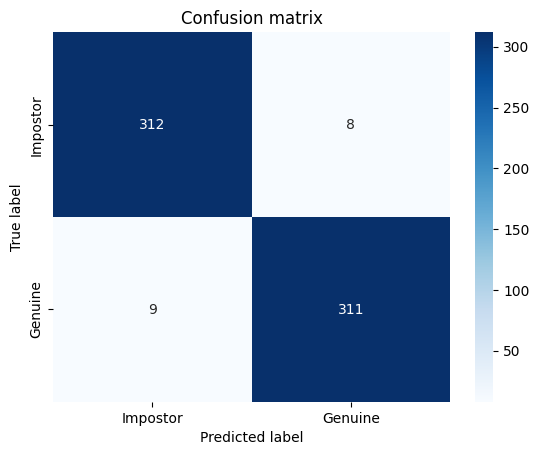

In [105]:
conf_matrix = calculate_confusion_matrix(test2_labels, y_pred, eer_threshold)
print("混淆矩陣:\n", conf_matrix)

tn, fp, fn, tp = conf_matrix.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

class_names = ["Impostor", "Genuine"]
plot_confusion_matrix(conf_matrix, class_names)